
# Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import math
import lightgbm as ltb
# !pip install catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model

# Load The Data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/data/covid-19-mrna-vaccine-degradation-41/train.csv")
test = pd.read_csv("/content/drive/MyDrive/data/covid-19-mrna-vaccine-degradation-41/test.csv")

In [ ]:
train.head()

,id,id_seqpos,sequence,structure,predicted_loop_type,reactivity,reactivity_error,deg_Mg_pH10,deg_error_Mg_pH10,deg_pH10,...,b4_structure,a4_structure,b4_predicted_loop_type,a4_predicted_loop_type,b5_sequence,a5_sequence,b5_structure,a5_structure,b5_predicted_loop_type,a5_predicted_loop_type
0,id_159f0ff46,id_159f0ff46_44,A,.,H,1.7786,0.1195,0.7346,0.0790,0.3680,...,(,),S,S,C,A,.,),I,S
1,id_d73546f4e,id_d73546f4e_38,G,.,I,0.4397,0.1033,0.1630,0.0799,0.0878,...,(,.,S,H,C,C,.,.,B,H
2,id_f3037fedf,id_f3037fedf_34,G,(,S,0.1120,0.1375,0.0000,0.0744,0.1835,...,(,(,S,S,A,G,(,(,S,S
3,id_468300749,id_468300749_12,G,(,S,0.0622,0.0471,0.1179,0.1075,0.0657,...,.,(,E,S,A,U,.,(,E,S
4,id_69e3878a2,id_69e3878a2_28,U,(,S,0.1378,0.1352,0.4069,0.2168,0.3375,...,(,(,S,S,G,G,(,.,S,H


In [ ]:
# target=df_train[['reactivity','deg_Mg_pH10','deg_Mg_50C']]
# df_train.drop(['reactivity','deg_Mg_pH10','deg_Mg_50C'],inplace=True,axis=1)

In [ ]:
test.head()

,id,id_seqpos,sequence,structure,predicted_loop_type,reactivity_error,deg_error_Mg_pH10,deg_pH10,deg_error_pH10,deg_error_Mg_50C,...,b4_structure,a4_structure,b4_predicted_loop_type,a4_predicted_loop_type,b5_sequence,a5_sequence,b5_structure,a5_structure,b5_predicted_loop_type,a5_predicted_loop_type
0,id_001f94081,id_001f94081_0,G,.,E,0.1359,0.2613,2.3375,0.2631,0.1501,...,-1,.,-1,E,-1,A,-1,(,-1,S
1,id_001f94081,id_001f94081_4,A,.,E,0.1314,0.1798,0.2635,0.1000,0.1369,...,.,(,E,S,-1,C,-1,(,-1,S
2,id_001f94081,id_001f94081_8,U,(,S,0.0756,0.1056,0.0530,0.0517,0.0705,...,.,.,E,H,A,U,.,.,E,H
3,id_001f94081,id_001f94081_9,C,(,S,0.1087,0.1896,0.5348,0.1474,0.1588,...,(,.,S,H,A,A,.,.,E,H
4,id_001f94081,id_001f94081_13,U,.,H,0.1388,0.1810,0.7699,0.1417,0.1382,...,(,.,S,H,U,G,(,),S,S


# EDA

### Train data

In [ ]:
train.shape

(130560, 45)

In [ ]:
train

,id,id_seqpos,sequence,structure,predicted_loop_type,reactivity,reactivity_error,deg_Mg_pH10,deg_error_Mg_pH10,deg_pH10,...,b4_structure,a4_structure,b4_predicted_loop_type,a4_predicted_loop_type,b5_sequence,a5_sequence,b5_structure,a5_structure,b5_predicted_loop_type,a5_predicted_loop_type
0,id_159f0ff46,id_159f0ff46_44,A,.,H,1.7786,0.1195,0.7346,0.0790,0.3680,...,(,),S,S,C,A,.,),I,S
1,id_d73546f4e,id_d73546f4e_38,G,.,I,0.4397,0.1033,0.1630,0.0799,0.0878,...,(,.,S,H,C,C,.,.,B,H
2,id_f3037fedf,id_f3037fedf_34,G,(,S,0.1120,0.1375,0.0000,0.0744,0.1835,...,(,(,S,S,A,G,(,(,S,S
3,id_468300749,id_468300749_12,G,(,S,0.0622,0.0471,0.1179,0.1075,0.0657,...,.,(,E,S,A,U,.,(,E,S
4,id_69e3878a2,id_69e3878a2_28,U,(,S,0.1378,0.1352,0.4069,0.2168,0.3375,...,(,(,S,S,G,G,(,.,S,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130555,id_796128149,id_796128149_27,U,),S,0.1244,0.0393,0.2672,0.0728,0.1479,...,),),S,S,A,A,.,.,H,M
130556,id_8a466e770,id_8a466e770_39,A,.,X,0.0201,0.0351,0.1271,0.0583,0.0580,...,.,.,H,X,A,U,.,.,H,X
130557,id_998669e76,id_998669e76_52,A,.,H,0.4597,0.0601,0.2014,0.0515,0.2838,...,.,.,H,I,U,U,.,),H,S
130558,id_6fe4a1abc,id_6fe4a1abc_45,G,.,I,0.3634,0.1063,0.1928,0.0738,0.1885,...,),.,S,I,G,G,),),S,S


In [ ]:
# reactivity
# deg_Mg_pH10
# deg_Mg_50C

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130560 entries, 0 to 130559
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      130560 non-null  object 
 1   id_seqpos               130560 non-null  object 
 2   sequence                130560 non-null  object 
 3   structure               130560 non-null  object 
 4   predicted_loop_type     130560 non-null  object 
 5   reactivity              130560 non-null  float64
 6   reactivity_error        130560 non-null  float64
 7   deg_Mg_pH10             130560 non-null  float64
 8   deg_error_Mg_pH10       130560 non-null  float64
 9   deg_pH10                130560 non-null  float64
 10  deg_error_pH10          130560 non-null  float64
 11  deg_Mg_50C              130560 non-null  float64
 12  deg_error_Mg_50C        130560 non-null  float64
 13  deg_50C                 130560 non-null  float64
 14  deg_error_50C       

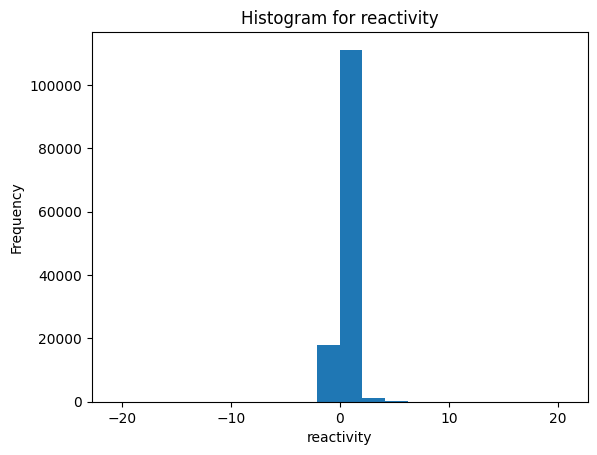

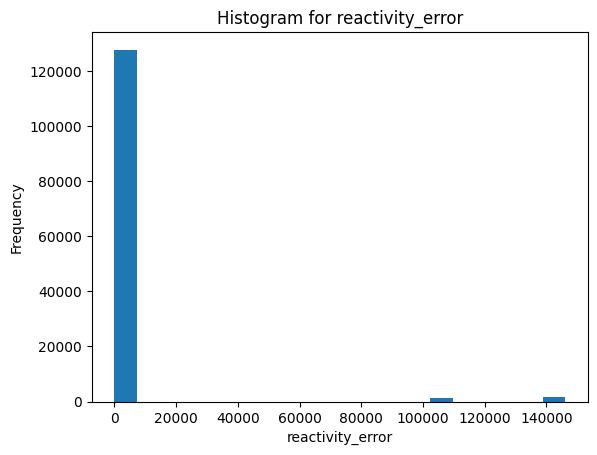

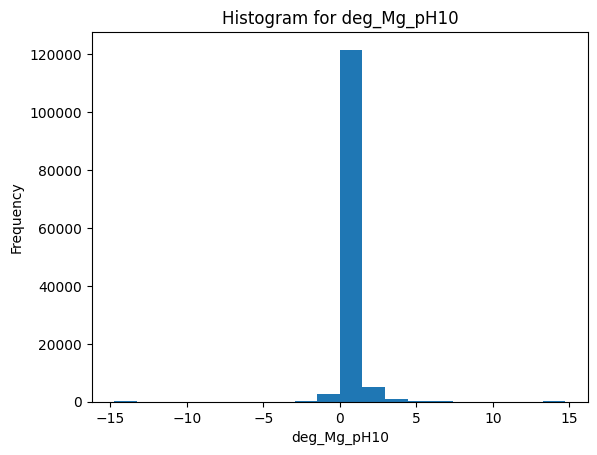

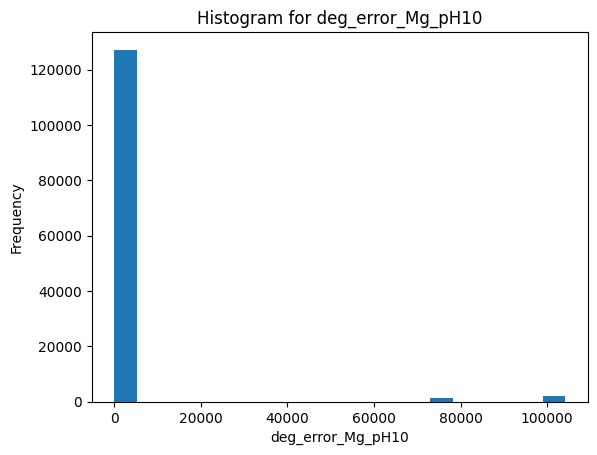

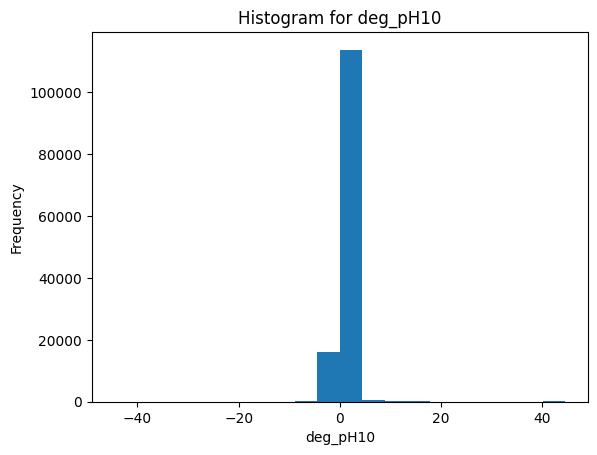

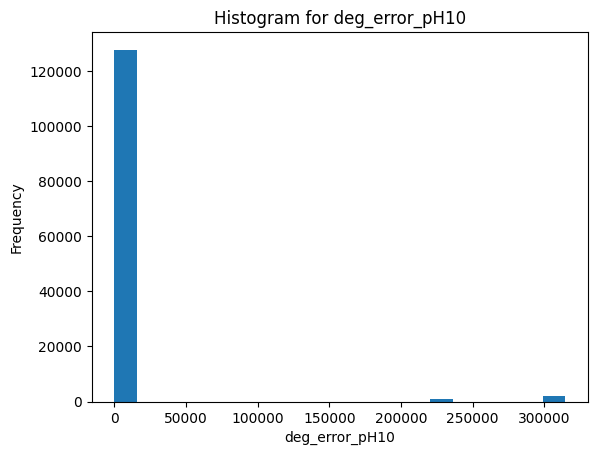

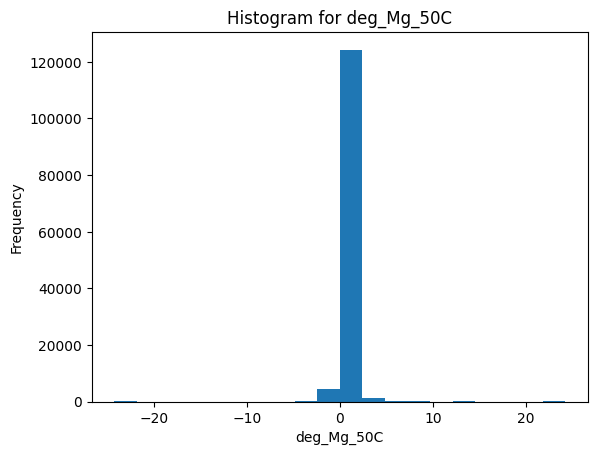

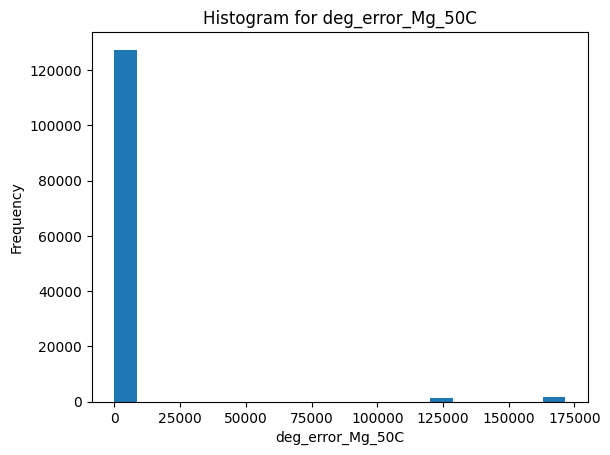

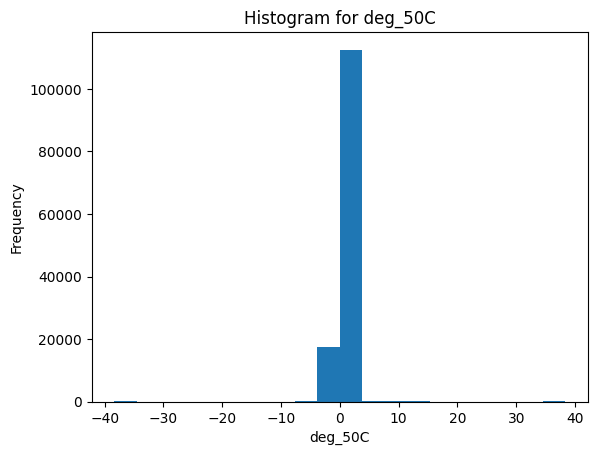

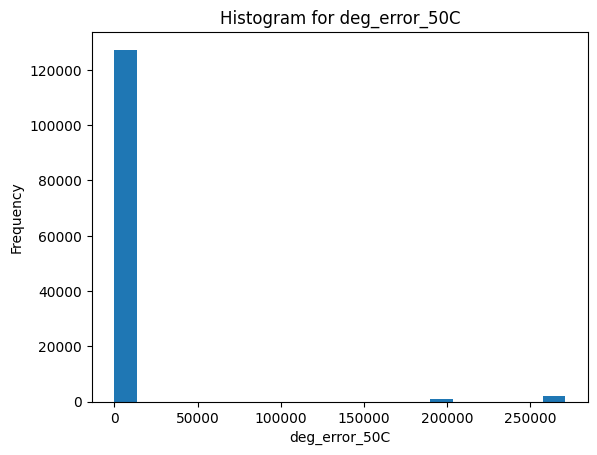

In [ ]:
for col in ['reactivity', 'reactivity_error', 'deg_Mg_pH10', 'deg_error_Mg_pH10', 'deg_pH10', 'deg_error_pH10', 'deg_Mg_50C', 'deg_error_Mg_50C', 'deg_50C', 'deg_error_50C']:
    plt.hist(train[col], bins=20)
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


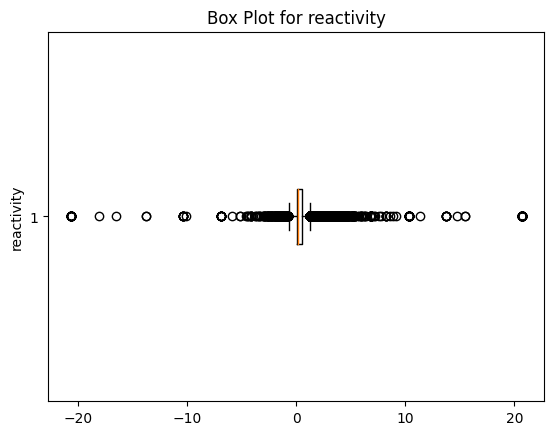

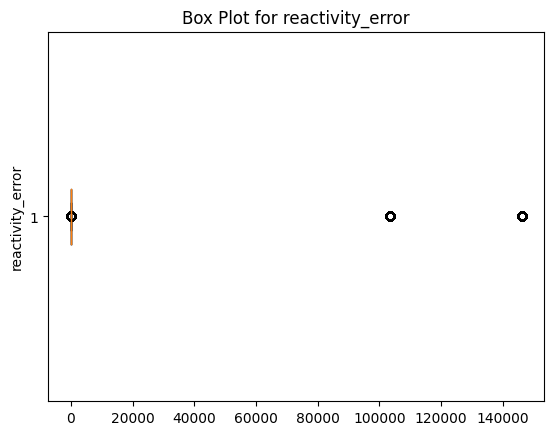

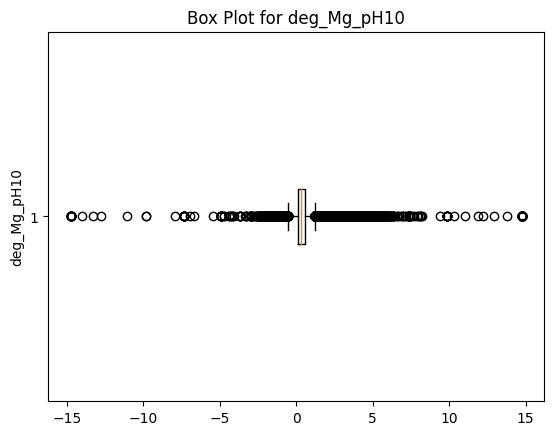

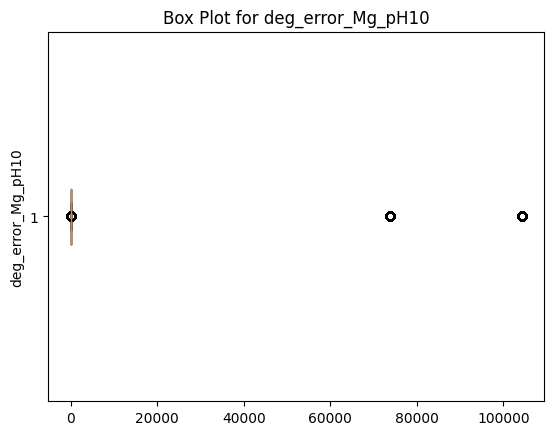

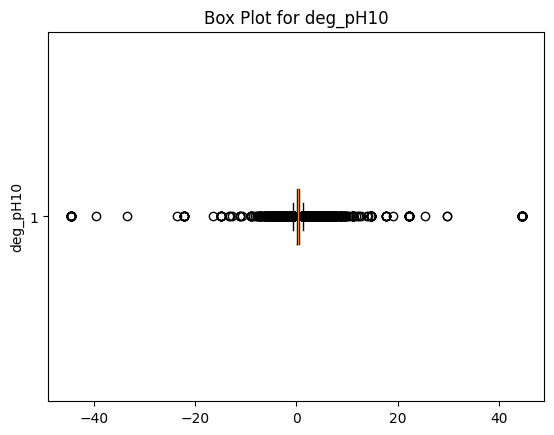

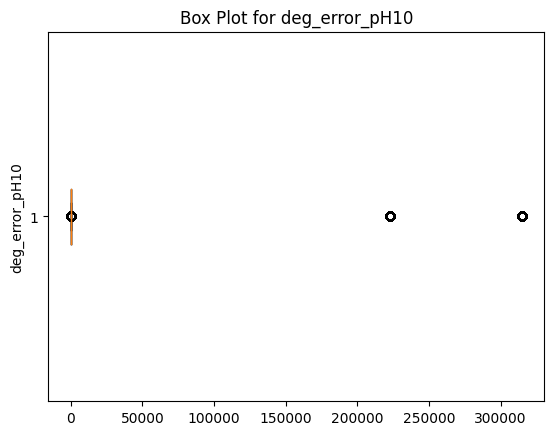

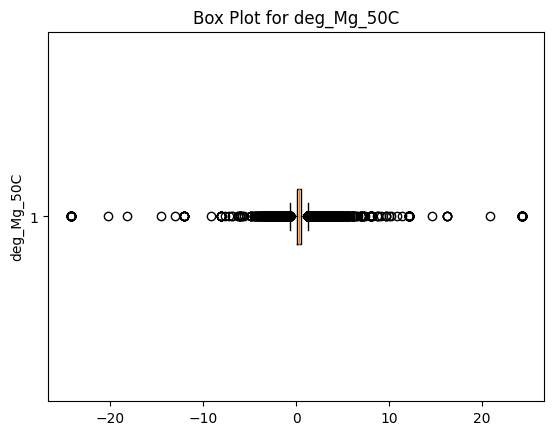

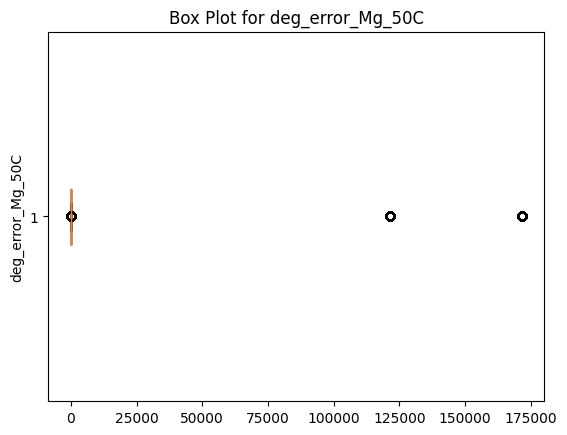

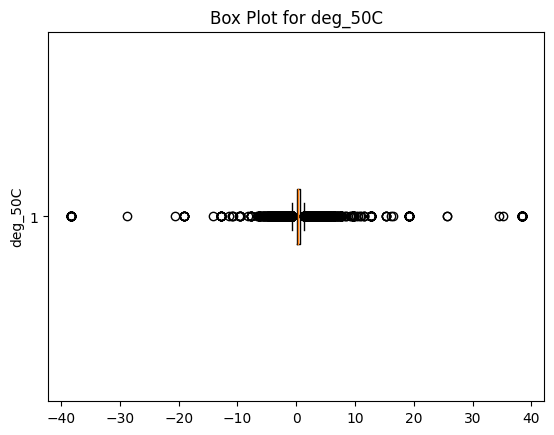

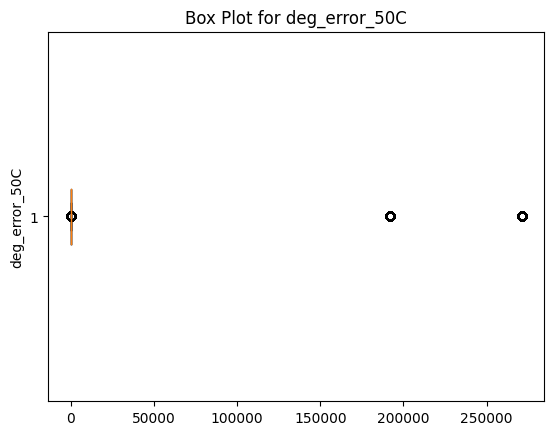

In [ ]:
for col in ['reactivity', 'reactivity_error', 'deg_Mg_pH10', 'deg_error_Mg_pH10', 'deg_pH10', 'deg_error_pH10', 'deg_Mg_50C', 'deg_error_Mg_50C', 'deg_50C', 'deg_error_50C']:
    plt.boxplot(train[col], vert=False)
    plt.title(f'Box Plot for {col}')
    plt.ylabel(col)
    plt.show()

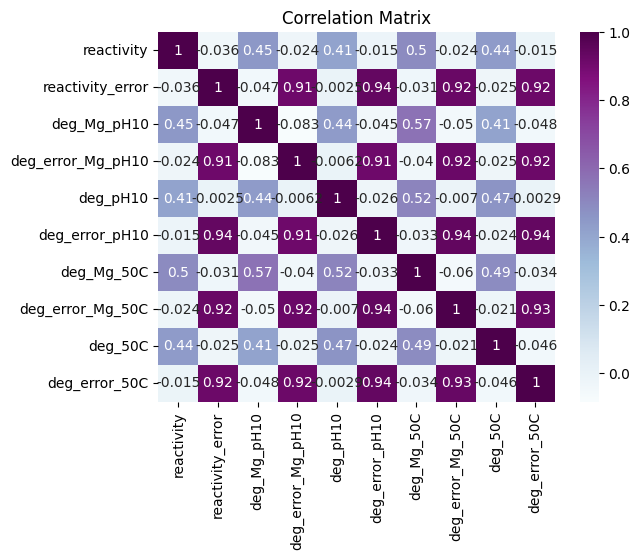

In [ ]:
correlation_matrix = train[['reactivity', 'reactivity_error', 'deg_Mg_pH10', 'deg_error_Mg_pH10', 'deg_pH10', 'deg_error_pH10', 'deg_Mg_50C', 'deg_error_Mg_50C', 'deg_50C', 'deg_error_50C']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="BuPu")
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# import seaborn as sns

# sns.pairplot(train[['reactivity', 'reactivity_error', 'deg_Mg_pH10', 'deg_error_Mg_pH10', 'deg_pH10', 'deg_error_pH10', 'deg_Mg_50C', 'deg_error_Mg_50C', 'deg_50C', 'deg_error_50C']])
# plt.title('Pairplot of Numeric Columns')
# plt.show()

In [ ]:
train.describe()

,reactivity,reactivity_error,deg_Mg_pH10,deg_error_Mg_pH10,deg_pH10,deg_error_pH10,deg_Mg_50C,deg_error_Mg_50C,deg_50C,deg_error_50C
count,130560.000000,130560.000000,130560.00000,130560.000000,130560.000000,130560.000000,130560.000000,130560.000000,130560.000000,130560.000000
mean,0.376570,2825.710861,0.44650,2332.806124,0.448538,6288.673592,0.405686,3579.976118,0.427428,5969.595514
std,0.730013,19105.915817,0.70582,14614.719469,1.300353,42323.269166,0.840844,23229.704416,1.126904,38182.352844
min,-20.664800,0.001900,-14.74050,0.006100,-44.515300,0.008300,-24.252500,0.004100,-38.339900,0.006500
25%,0.043800,0.044900,0.13130,0.057200,0.099900,0.073900,0.074100,0.052000,0.092700,0.081300
50%,0.216200,0.083000,0.28990,0.098800,0.276100,0.120500,0.256800,0.088800,0.308800,0.133700
75%,0.540400,0.172500,0.56760,0.200000,0.569100,0.244200,0.560000,0.181600,0.613825,0.265325
max,20.667500,146151.225000,14.74010,104235.174200,44.521200,314833.569500,24.252500,171525.321700,38.343800,271158.604000


In [ ]:
summary_stats = train[['reactivity', 'reactivity_error', 'deg_Mg_pH10', 'deg_error_Mg_pH10', 'deg_pH10', 'deg_error_pH10', 'deg_Mg_50C', 'deg_error_Mg_50C', 'deg_50C', 'deg_error_50C']].describe()
print(summary_stats)

          reactivity  reactivity_error   deg_Mg_pH10  deg_error_Mg_pH10  \
count  130560.000000     130560.000000  130560.00000      130560.000000   
mean        0.376570       2825.710861       0.44650        2332.806124   
std         0.730013      19105.915817       0.70582       14614.719469   
min       -20.664800          0.001900     -14.74050           0.006100   
25%         0.043800          0.044900       0.13130           0.057200   
50%         0.216200          0.083000       0.28990           0.098800   
75%         0.540400          0.172500       0.56760           0.200000   
max        20.667500     146151.225000      14.74010      104235.174200   

            deg_pH10  deg_error_pH10     deg_Mg_50C  deg_error_Mg_50C  \
count  130560.000000   130560.000000  130560.000000     130560.000000   
mean        0.448538     6288.673592       0.405686       3579.976118   
std         1.300353    42323.269166       0.840844      23229.704416   
min       -44.515300        0.00

In [ ]:
categorical_columns = [
    'b1_sequence', 'a1_sequence', 'b1_structure', 'a1_structure', 'b1_predicted_loop_type', 'a1_predicted_loop_type',
    'b2_sequence', 'a2_sequence', 'b2_structure', 'a2_structure', 'b2_predicted_loop_type', 'a2_predicted_loop_type',
    'b3_sequence', 'a3_sequence', 'b3_structure', 'a3_structure', 'b3_predicted_loop_type', 'a3_predicted_loop_type',
    'b4_sequence', 'a4_sequence', 'b4_structure', 'a4_structure', 'b4_predicted_loop_type', 'a4_predicted_loop_type',
    'b5_sequence', 'a5_sequence', 'b5_structure', 'a5_structure', 'b5_predicted_loop_type', 'a5_predicted_loop_type',
    'sequence', 'structure', 'predicted_loop_type'
]

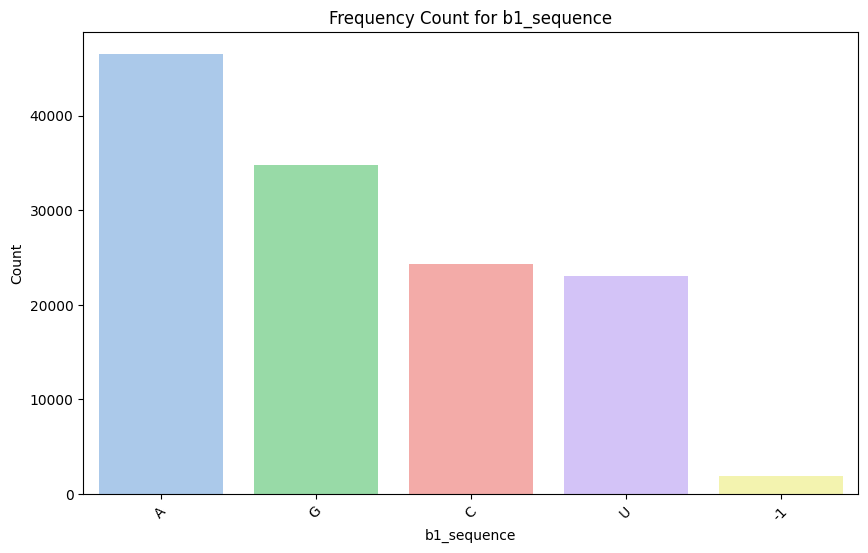

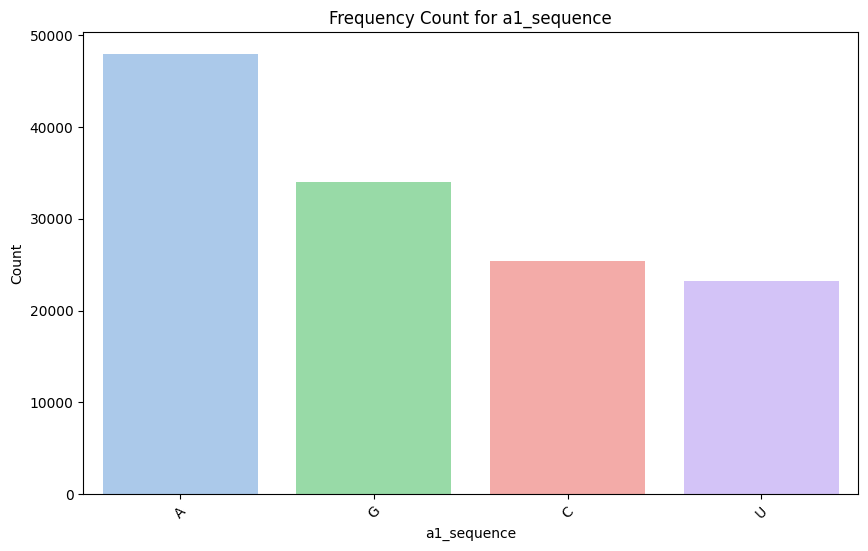

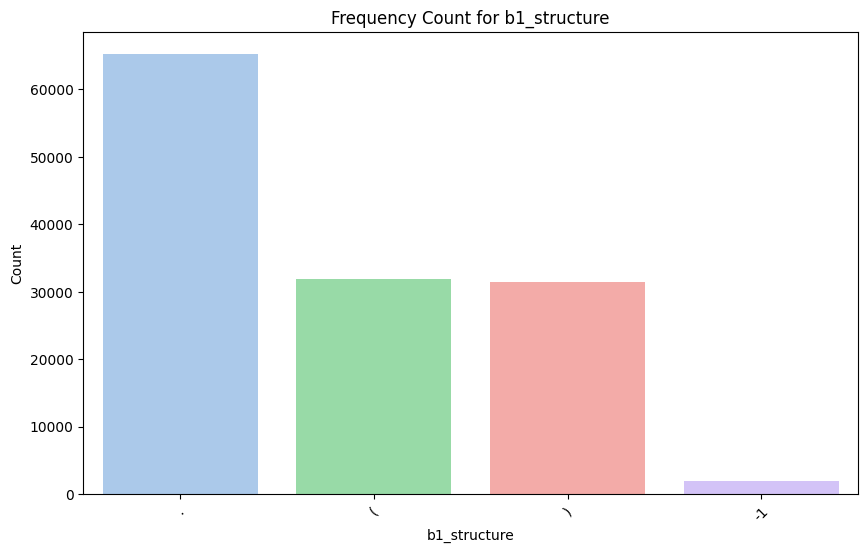

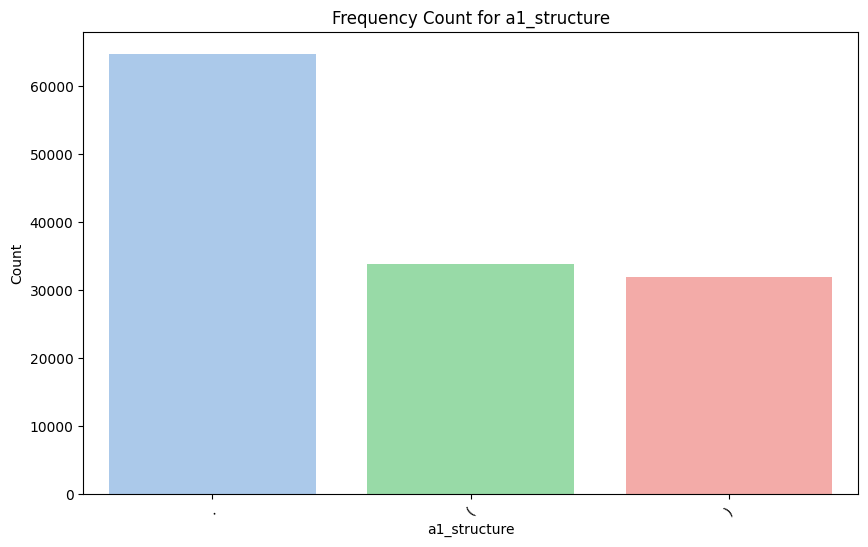

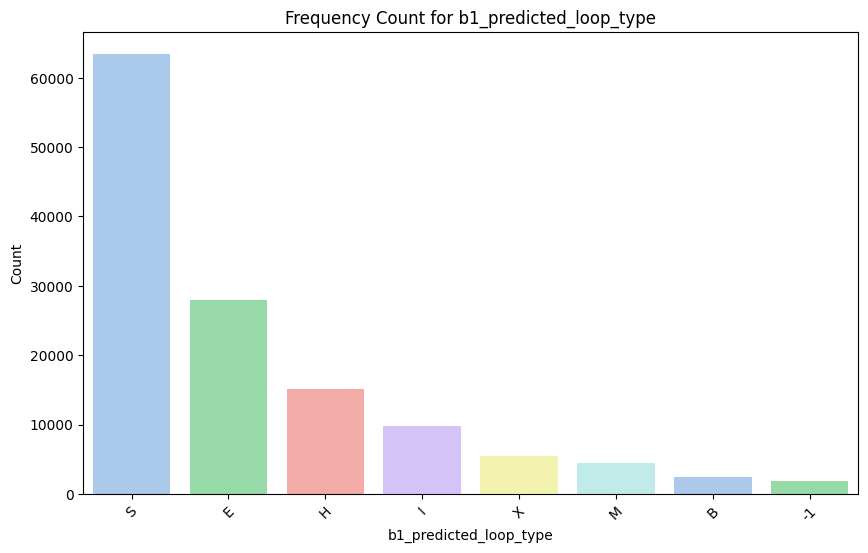

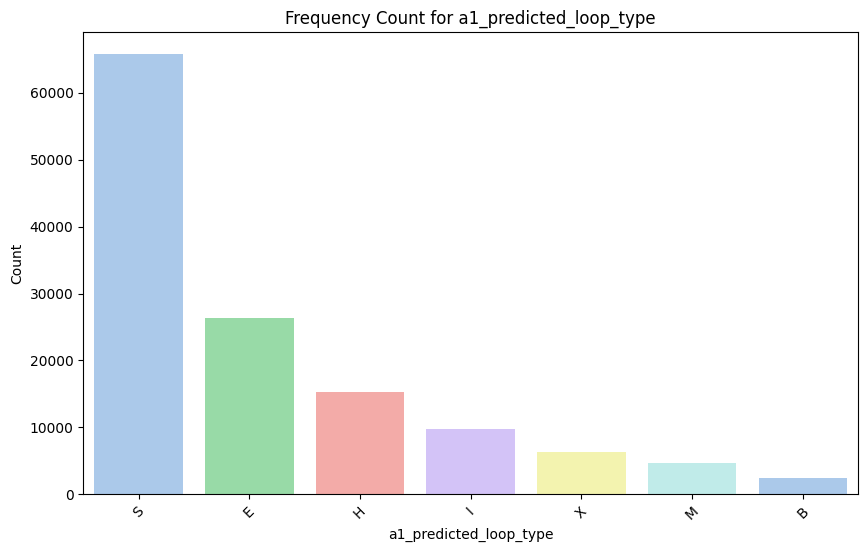

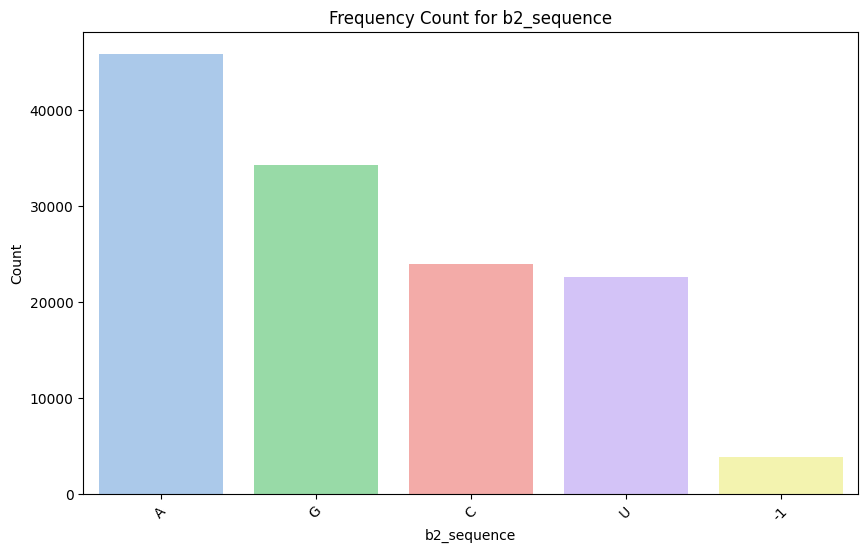

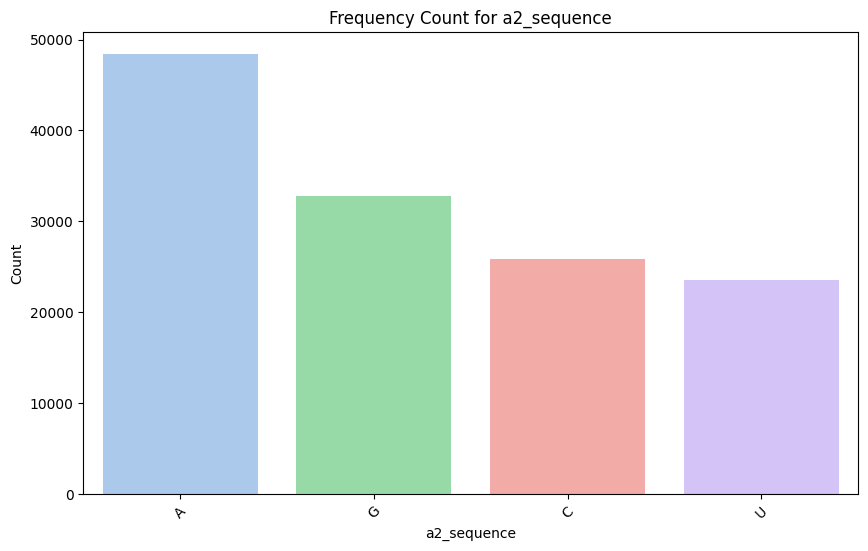

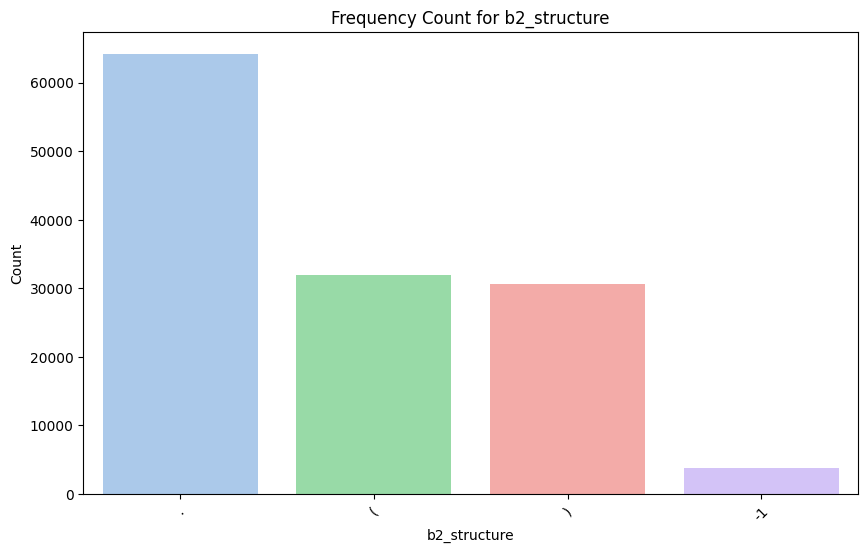

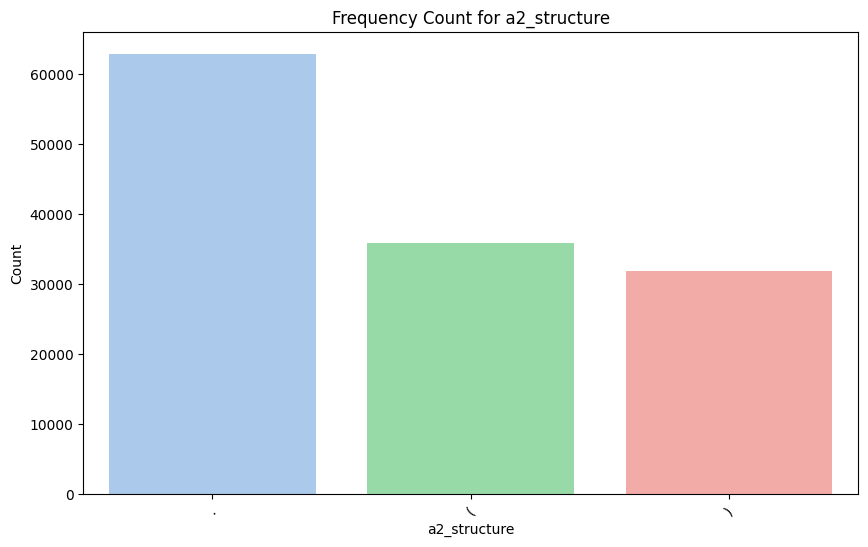

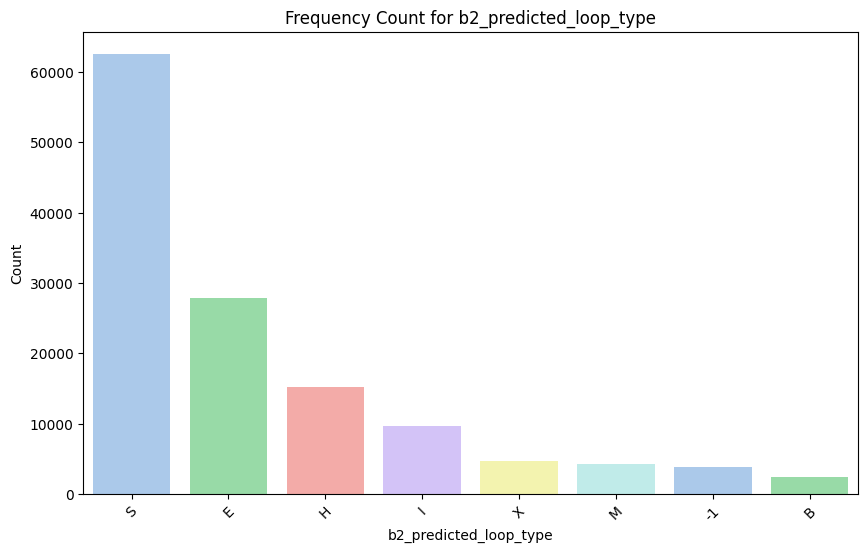

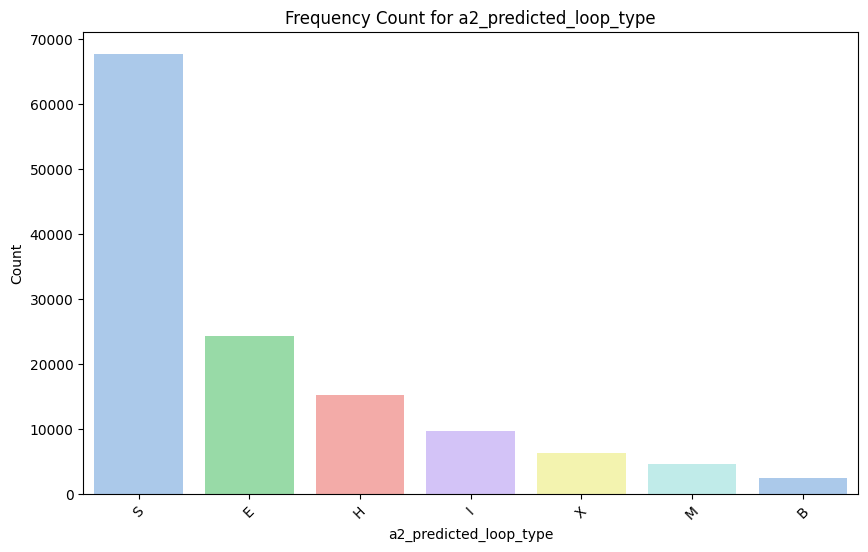

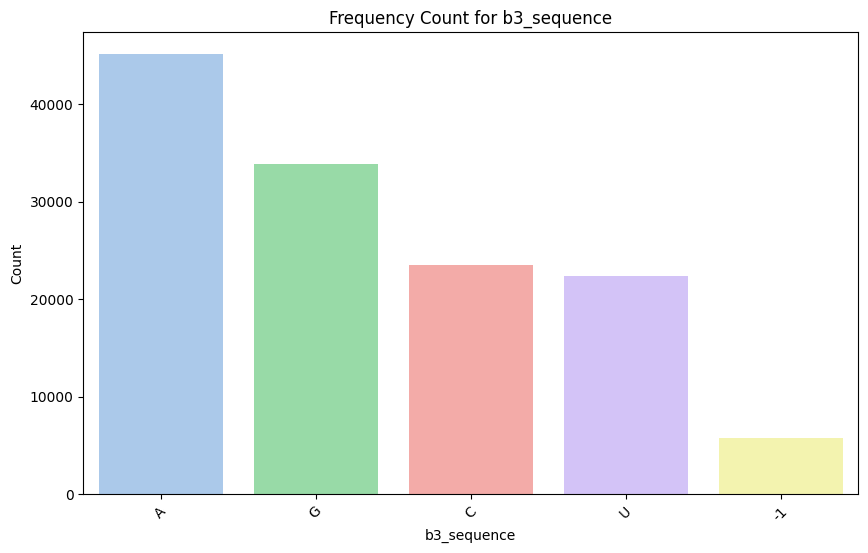

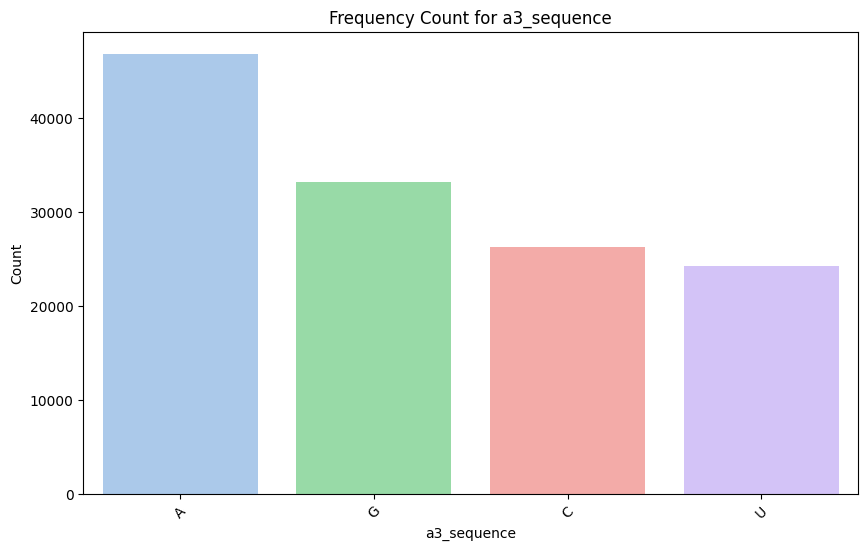

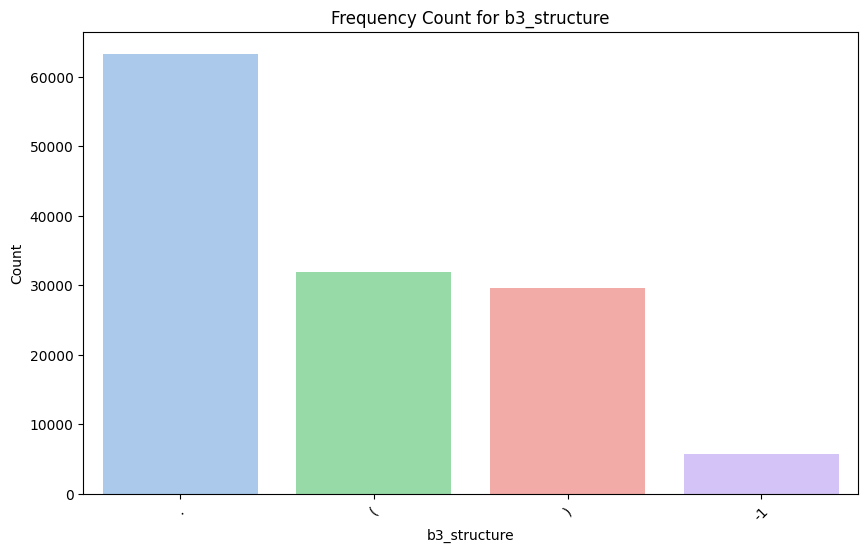

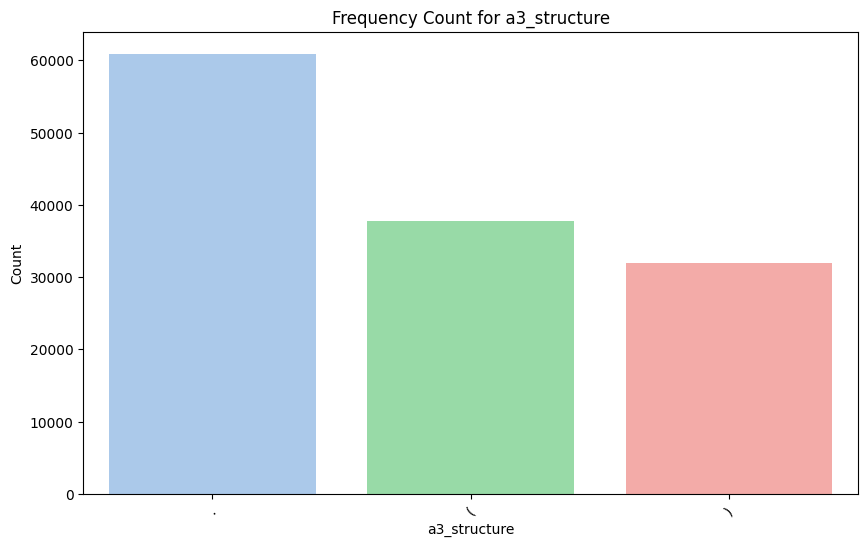

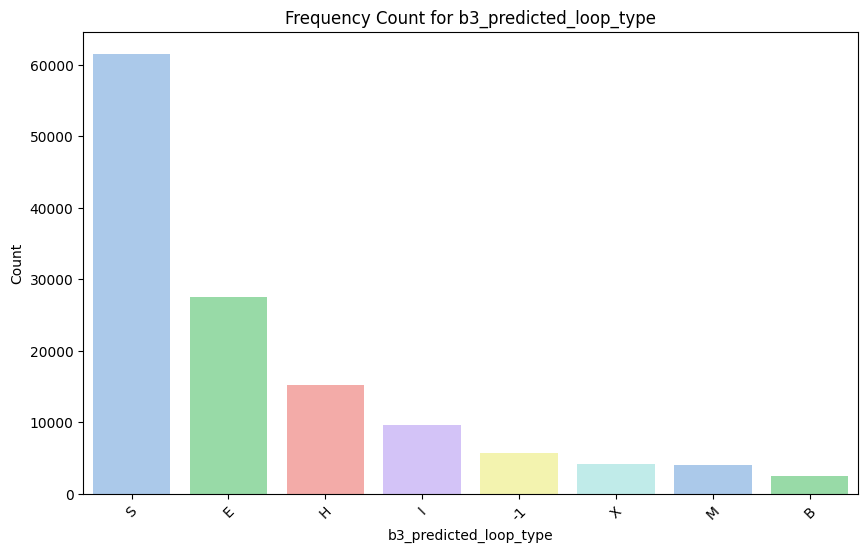

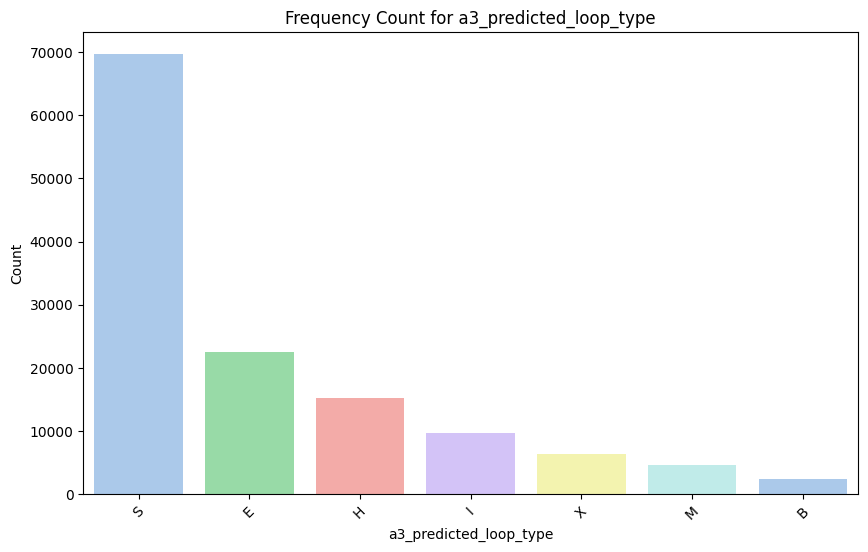

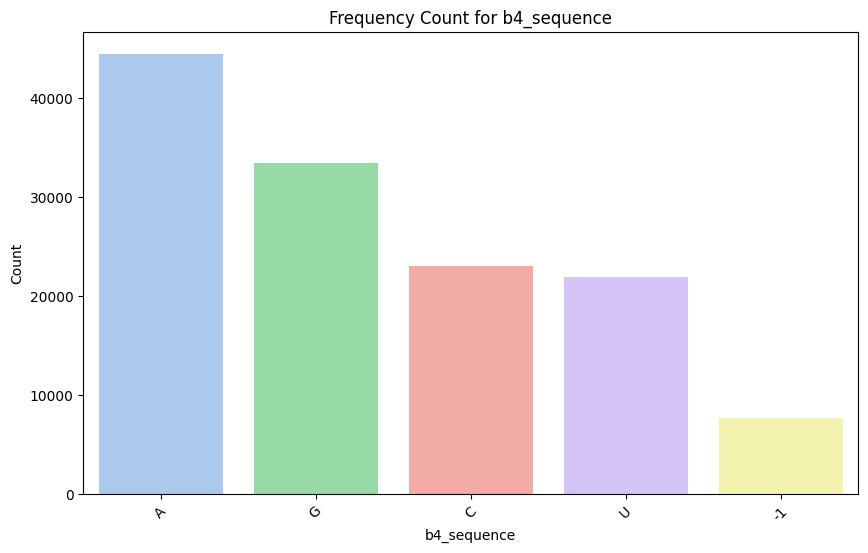

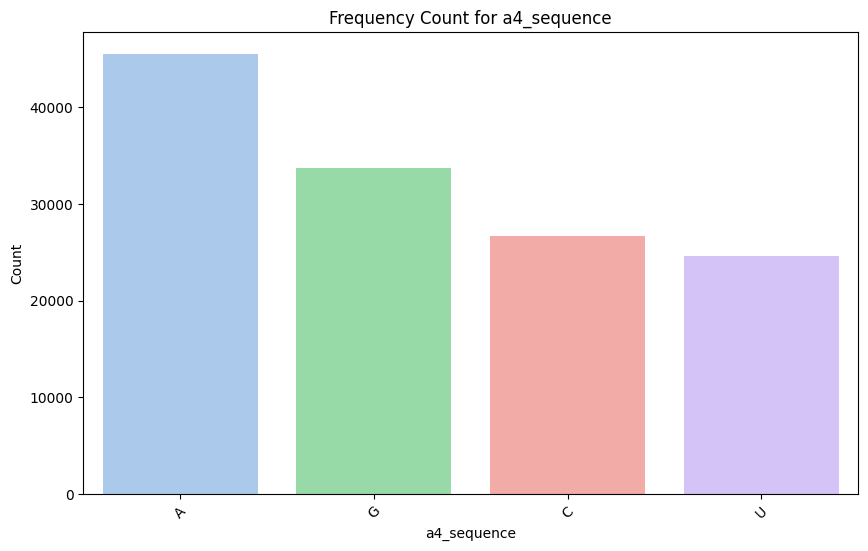

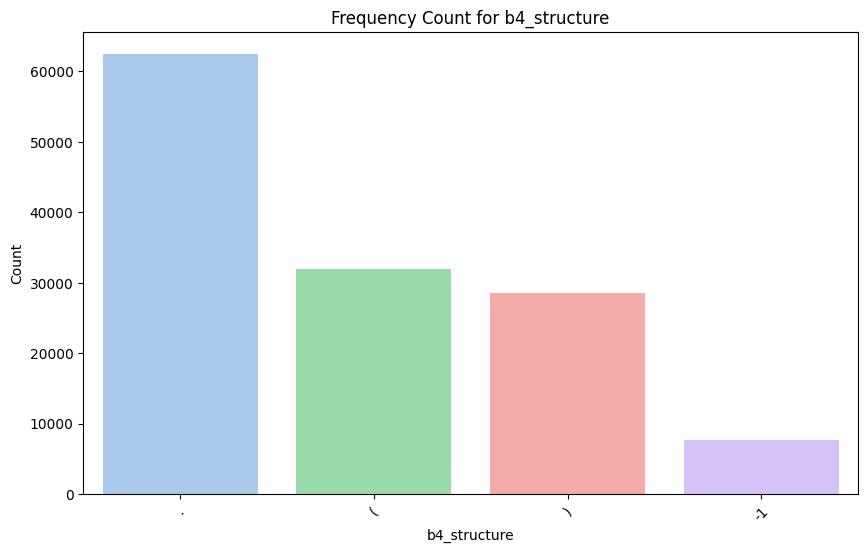

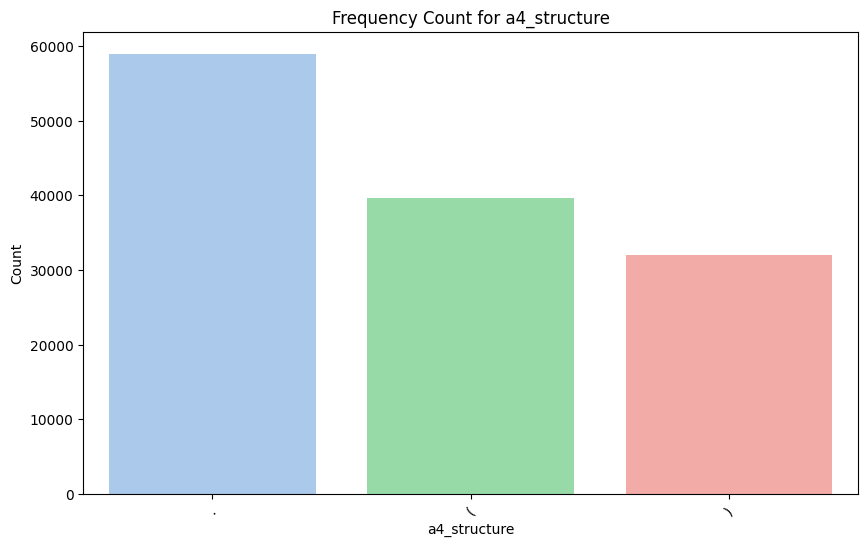

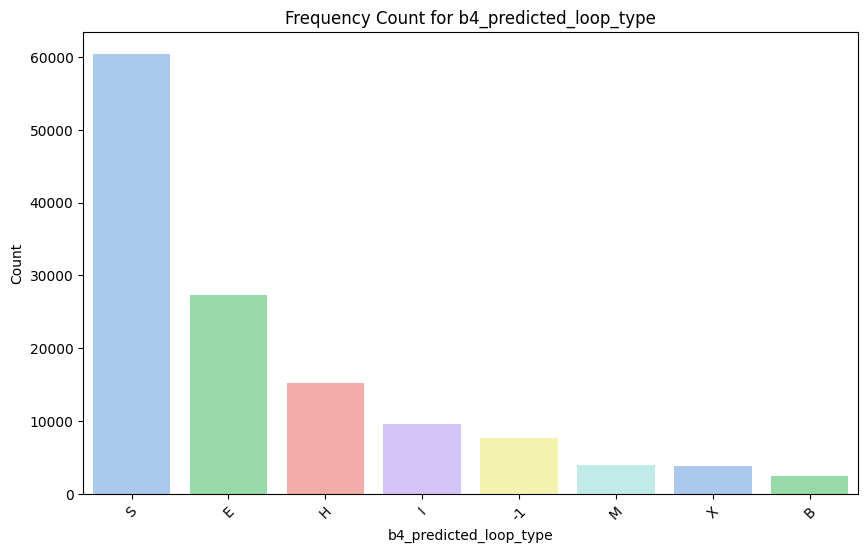

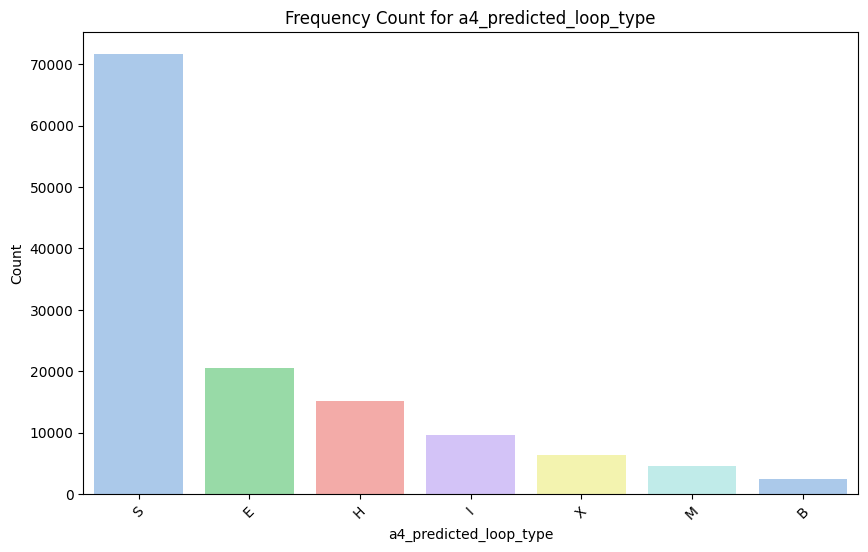

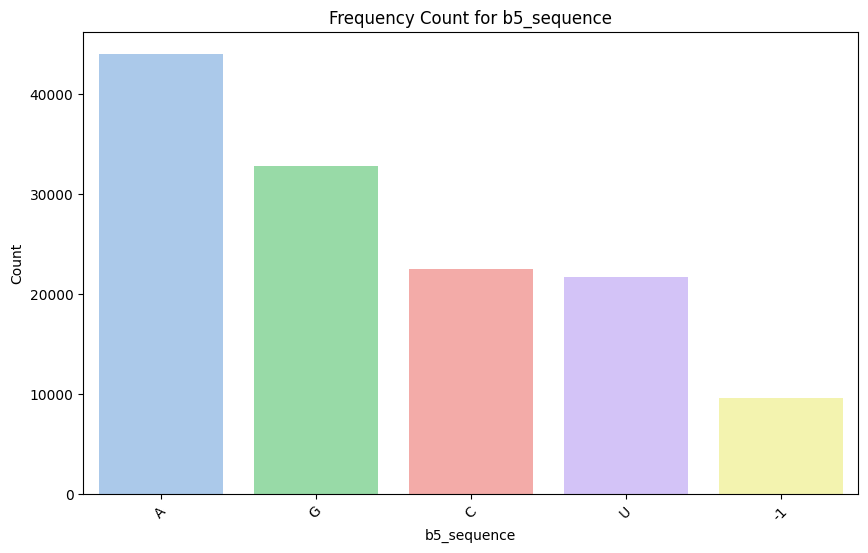

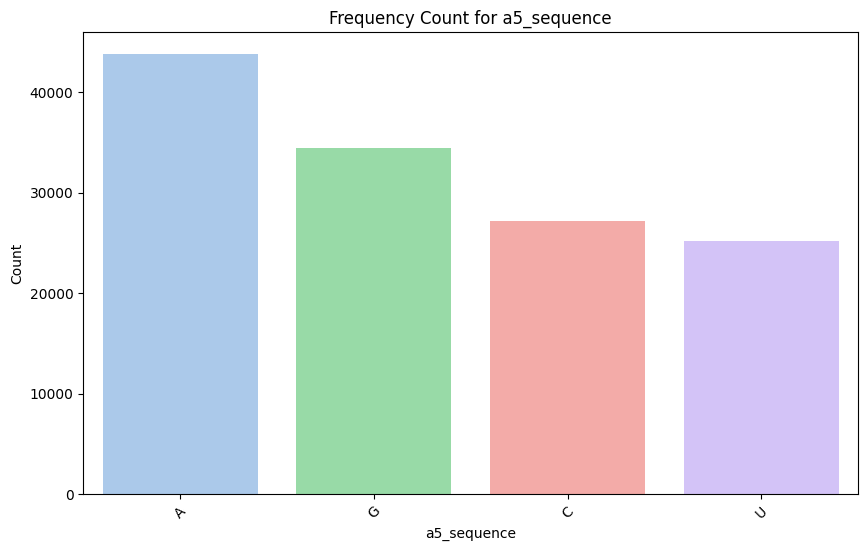

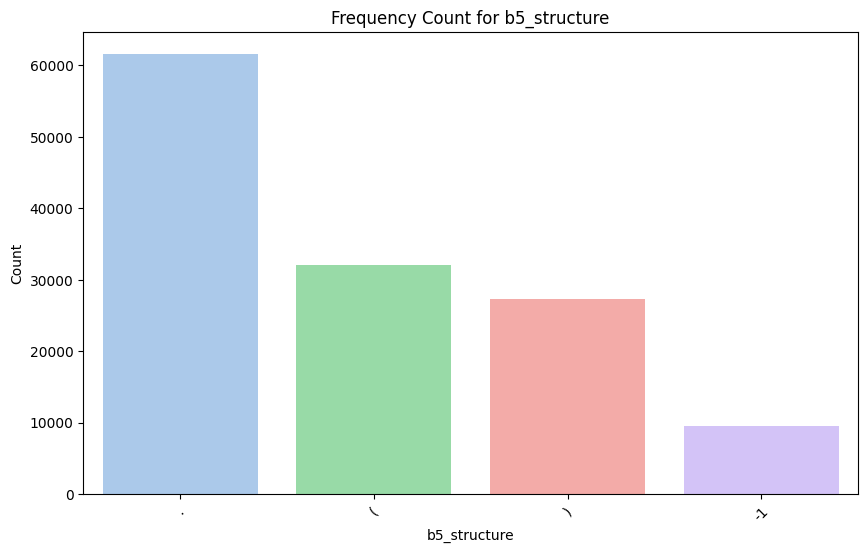

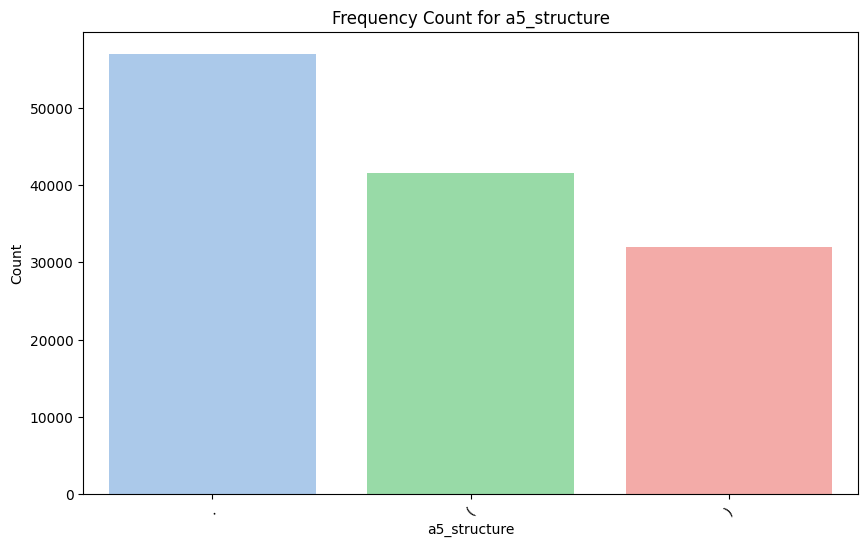

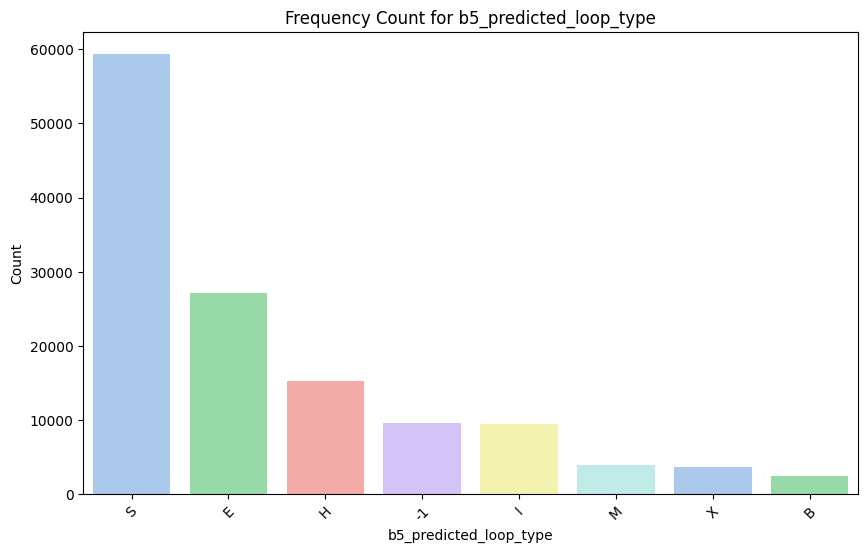

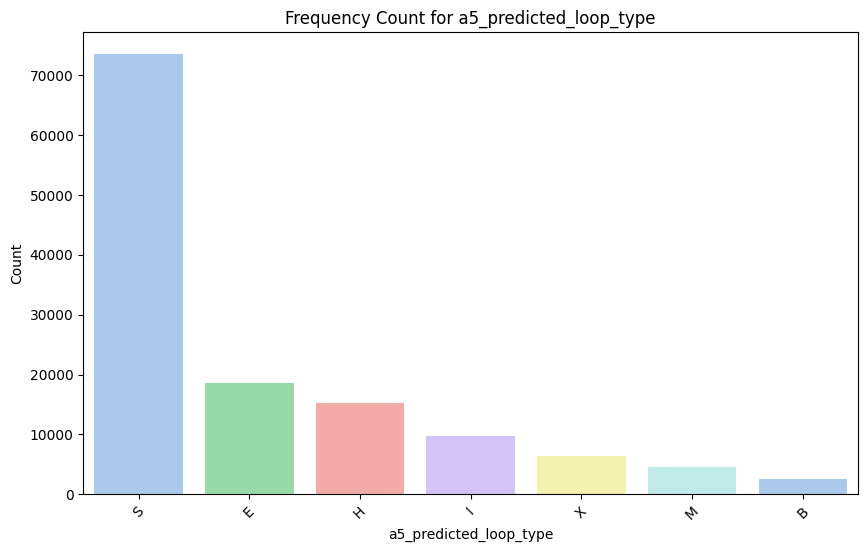

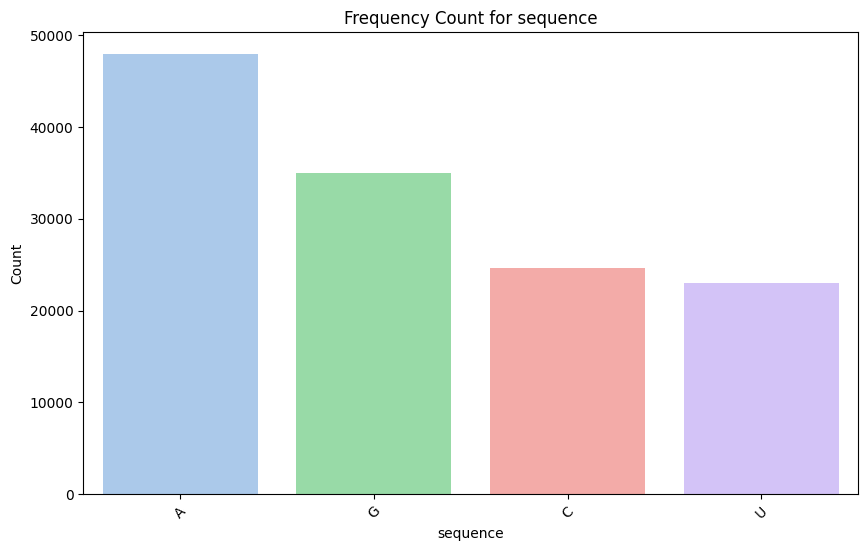

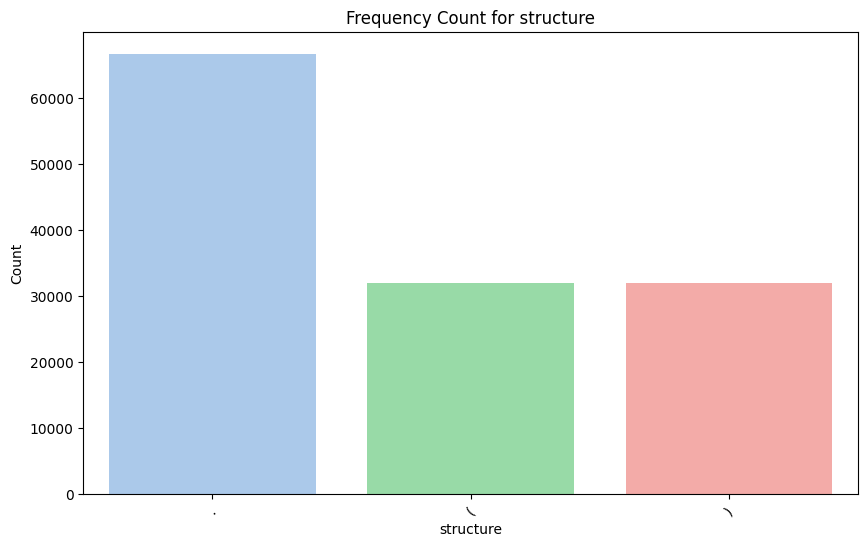

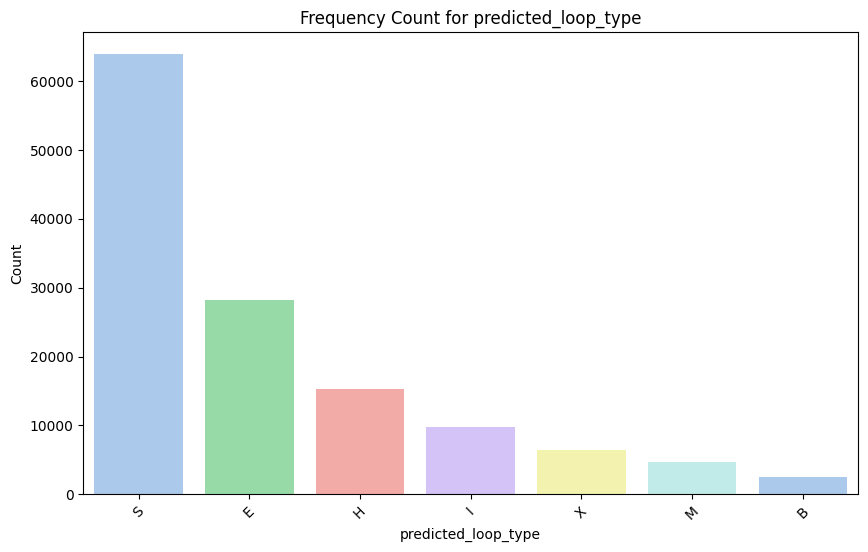

In [ ]:
# Define a custom color palette
custom_palette = sns.color_palette("pastel6", len(categorical_columns))

# Loop through each categorical column for EDA
for col in categorical_columns:
    plt.figure(figsize=(10, 6))  # Adjust figsize as needed
    sns.countplot(data=train, x=col, order=train[col].value_counts().index, palette=custom_palette)
    plt.title(f'Frequency Count for {col}')
    plt.xlabel(col)
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed for readability
    plt.ylabel('Count')
    plt.show()

In [ ]:
for col in categorical_columns:
    freq_table = train[col].value_counts().reset_index()
    freq_table.columns = [col, 'Count']
    freq_table['Percentage'] = (freq_table['Count'] / len(train)) * 100
    print(f'Frequency Table for {col}:\n{freq_table}\n')

Frequency Table for b1_sequence:
  b1_sequence  Count  Percentage
0           A  46512   35.625000
1           G  34784   26.642157
2           C  24290   18.604473
3           U  23070   17.670037
4          -1   1904    1.458333

Frequency Table for a1_sequence:
  a1_sequence  Count  Percentage
0           A  47936   36.715686
1           G  34035   26.068474
2           C  25398   19.453125
3           U  23191   17.762714

Frequency Table for b1_structure:
  b1_structure  Count  Percentage
0            .  65243   49.971661
1            (  31948   24.469975
2            )  31465   24.100031
3           -1   1904    1.458333

Frequency Table for a1_structure:
  a1_structure  Count  Percentage
0            .  64786    49.62163
1            (  33869    25.94133
2            )  31905    24.43704

Frequency Table for b1_predicted_loop_type:
  b1_predicted_loop_type  Count  Percentage
0                      S  63413   48.570006
1                      E  28019   21.460631
2                

In [ ]:
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            cross_tab = pd.crosstab(train[col1], train[col2])
            print(f'Cross-tabulation between {col1} and {col2}:\n{cross_tab}\n')


Streaming output truncated to the last 5000 lines.
B                         800    578    664    410
E                       11922   4521   5218   5930
H                        4764   3442   3965   3111
I                        3247   1984   2821   1618
M                        1337    880   1091    739
S                       18845  13733  18046  10917
X                        1726    737    987    782

Cross-tabulation between b3_predicted_loop_type and b2_structure:
b2_structure                (      )    -1      .
b3_predicted_loop_type                           
-1                          1      0  3803   1941
B                         633    689     0   1130
E                        1687      0     0  25904
H                           0   3026     0  12256
I                        2498   2421     0   4751
M                         761    227     0   3059
S                       25981  24296     0  11264
X                         367      0     0   3865

Cross-tabulation between

In [ ]:
train.drop(['id', 'id_seqpos'],axis=1,inplace=True)
cat_data=train.select_dtypes("object")
Num_data=train.select_dtypes(exclude="object")

### Test data

In [ ]:
test.shape

(32640, 42)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32640 entries, 0 to 32639
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      32640 non-null  object 
 1   id_seqpos               32640 non-null  object 
 2   sequence                32640 non-null  object 
 3   structure               32640 non-null  object 
 4   predicted_loop_type     32640 non-null  object 
 5   reactivity_error        32640 non-null  float64
 6   deg_error_Mg_pH10       32640 non-null  float64
 7   deg_pH10                32640 non-null  float64
 8   deg_error_pH10          32640 non-null  float64
 9   deg_error_Mg_50C        32640 non-null  float64
 10  deg_50C                 32640 non-null  float64
 11  deg_error_50C           32640 non-null  float64
 12  b1_sequence             32640 non-null  object 
 13  a1_sequence             32640 non-null  object 
 14  b1_structure            32640 non-null

In [ ]:
summary_stats = test[['reactivity_error', 'deg_error_Mg_pH10', 'deg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_50C', 'deg_error_50C']].describe()
print(summary_stats)



       reactivity_error  deg_error_Mg_pH10      deg_pH10  deg_error_pH10  \
count      32640.000000       32640.000000  32640.000000    32640.000000   
mean        2867.711465        2332.851217      0.440402     6308.833647   
std        19219.425971       14677.383270      1.225579    42379.018394   
min            0.003400           0.009200    -44.515300        0.009400   
25%            0.044800           0.057100      0.098100        0.073700   
50%            0.083100           0.099400      0.271600        0.120800   
75%            0.174800           0.204600      0.565600        0.248600   
max       146151.225000      104235.174200     44.519700   314833.569500   

       deg_error_Mg_50C       deg_50C  deg_error_50C  
count      32640.000000  32640.000000   32640.000000  
mean        3591.413087      0.419736    6035.790535  
std        23269.401175      1.103974   38260.803049  
min            0.005700    -38.339900       0.008500  
25%            0.051900      0.090400   

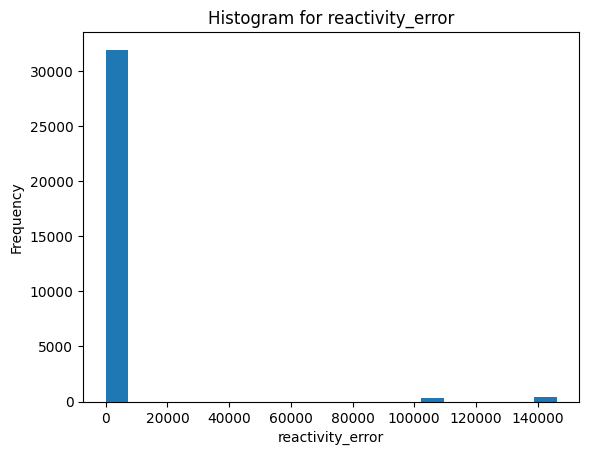

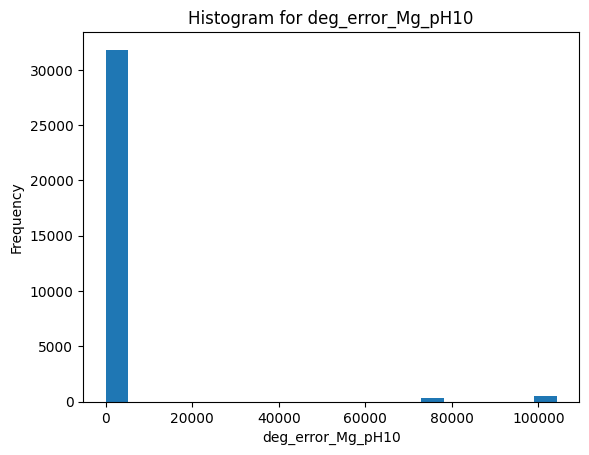

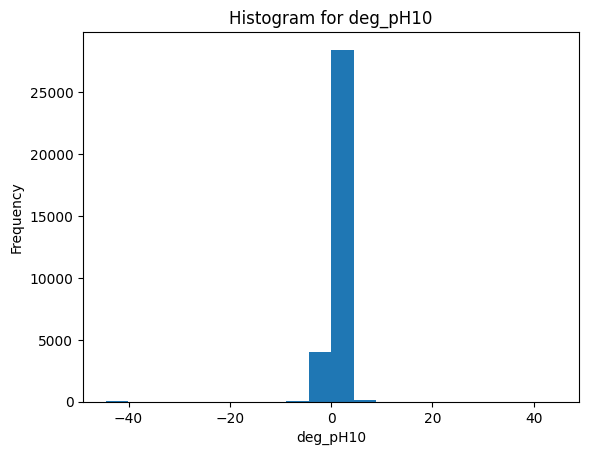

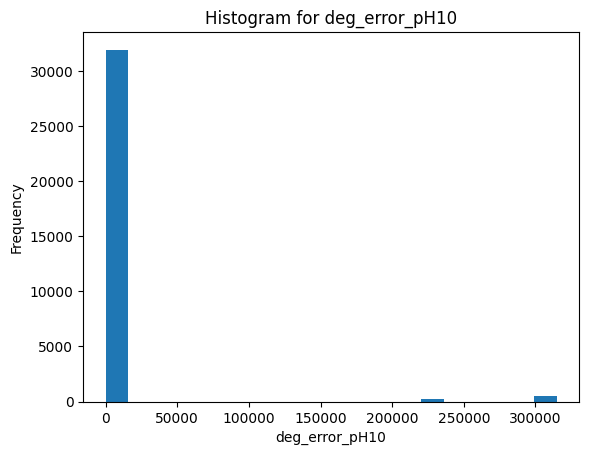

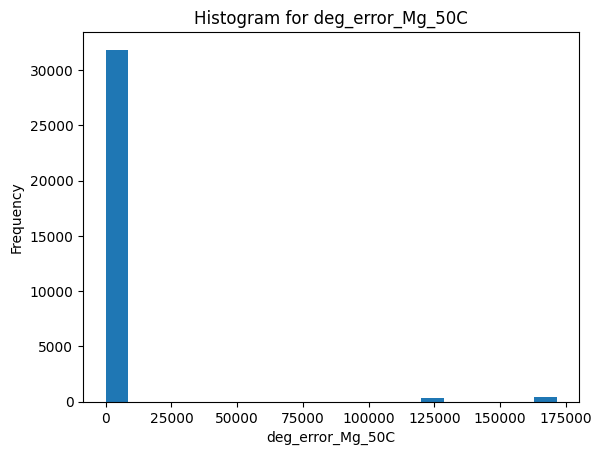

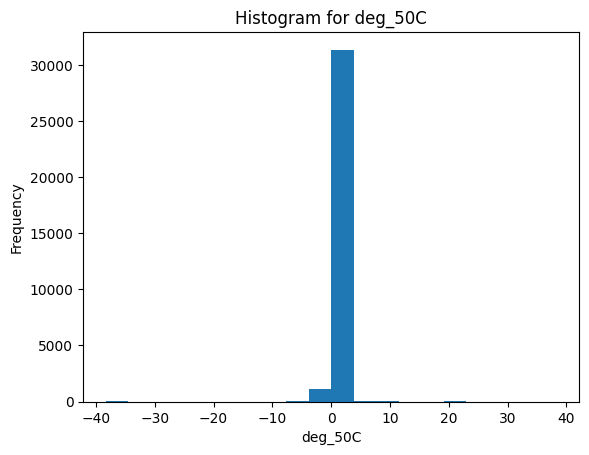

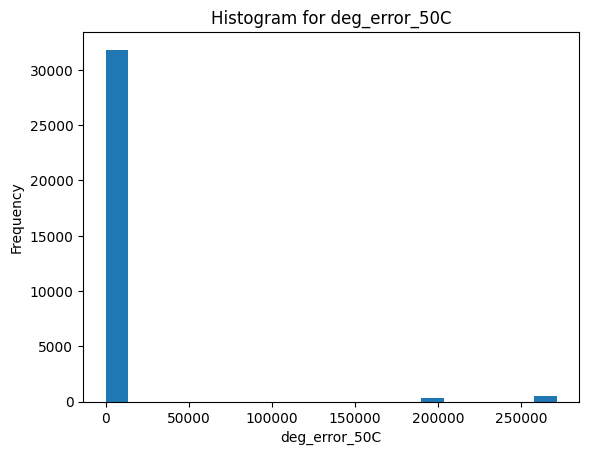

In [ ]:
for col in['reactivity_error', 'deg_error_Mg_pH10', 'deg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_50C', 'deg_error_50C']:
    plt.hist(test[col], bins=20)
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
id_test= test.id_seqpos
test.drop(['id', 'id_seqpos'],axis=1,inplace=True)
cat_test=test.select_dtypes("object")
Num_test=test.select_dtypes(exclude="object")

# Encoding

### Encoding

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
cat_data
OE = cat_data.columns
dic = {'(': 0,
       ')': 1,
       '.': 2,
       'A': 3,
       'C': 4,
       'G': 5,
       'U': 6,
       'B': 7,
       'E': 8,
       'H': 9,
       'I': 10,
       'M': 11,
       'S': 12,
       'X': 13,
       '-1': 14}
train[OE] = train[OE].replace(dic)
test[OE] = test[OE].replace(dic)

In [ ]:
train

,sequence,structure,predicted_loop_type,reactivity,reactivity_error,deg_Mg_pH10,deg_error_Mg_pH10,deg_pH10,deg_error_pH10,deg_Mg_50C,...,b4_structure,a4_structure,b4_predicted_loop_type,a4_predicted_loop_type,b5_sequence,a5_sequence,b5_structure,a5_structure,b5_predicted_loop_type,a5_predicted_loop_type
0,3,2,9,1.7786,0.1195,0.7346,0.0790,0.3680,0.0851,0.7228,...,0,1,12,12,4,3,2,1,10,12
1,5,2,10,0.4397,0.1033,0.1630,0.0799,0.0878,0.0878,0.1100,...,0,2,12,9,4,4,2,2,7,9
2,5,0,12,0.1120,0.1375,0.0000,0.0744,0.1835,0.1969,0.0933,...,0,0,12,12,3,5,0,0,12,12
3,5,0,12,0.0622,0.0471,0.1179,0.1075,0.0657,0.0615,0.0548,...,2,0,8,12,3,6,2,0,8,12
4,6,0,12,0.1378,0.1352,0.4069,0.2168,0.3375,0.2623,0.2378,...,0,0,12,12,5,5,0,2,12,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130555,6,1,12,0.1244,0.0393,0.2672,0.0728,0.1479,0.0493,0.1921,...,1,1,12,12,3,3,2,2,9,11
130556,3,2,13,0.0201,0.0351,0.1271,0.0583,0.0580,0.0660,0.0245,...,2,2,9,13,3,6,2,2,9,13
130557,3,2,9,0.4597,0.0601,0.2014,0.0515,0.2838,0.0793,0.2042,...,2,2,9,10,6,6,2,1,9,12
130558,5,2,10,0.3634,0.1063,0.1928,0.0738,0.1885,0.1276,0.1627,...,1,2,12,10,5,5,1,1,12,12


In [ ]:
test

,sequence,structure,predicted_loop_type,reactivity_error,deg_error_Mg_pH10,deg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_50C,deg_error_50C,...,b4_structure,a4_structure,b4_predicted_loop_type,a4_predicted_loop_type,b5_sequence,a5_sequence,b5_structure,a5_structure,b5_predicted_loop_type,a5_predicted_loop_type
0,5,2,8,0.1359,0.2613,2.3375,0.2631,0.1501,0.6382,0.2167,...,14,2,14,8,14,3,14,0,14,12
1,3,2,8,0.1314,0.1798,0.2635,0.1000,0.1369,0.7877,0.1703,...,2,0,8,12,14,4,14,0,14,12
2,6,0,12,0.0756,0.1056,0.0530,0.0517,0.0705,0.0585,0.0638,...,2,2,8,9,3,6,2,2,8,9
3,4,0,12,0.1087,0.1896,0.5348,0.1474,0.1588,0.7349,0.1804,...,0,2,12,9,3,3,2,2,8,9
4,6,2,9,0.1388,0.1810,0.7699,0.1417,0.1382,1.0442,0.1777,...,0,2,12,9,6,5,0,1,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32635,3,0,12,0.0091,0.0344,0.0140,0.0303,0.0284,0.0182,0.0376,...,0,0,12,12,4,3,0,2,12,9
32636,3,1,12,0.0237,0.0390,0.0806,0.0529,0.0361,0.0237,0.0447,...,1,1,12,12,5,5,1,1,12,12
32637,3,2,7,0.0655,0.0672,0.5538,0.1022,0.0694,0.4242,0.1039,...,2,1,11,12,5,4,1,1,12,12
32638,3,1,12,0.0218,0.0391,0.1642,0.0611,0.0520,0.1120,0.0612,...,1,0,12,12,6,4,1,0,12,12


# 4- Split data

In [ ]:
X = train.drop(['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C'], axis=1)
y = train[['reactivity','deg_Mg_pH10','deg_Mg_50C']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling

## Encoding 1

### XGBoost

In [ ]:
models = {}
for col in y.columns:
    model = xgb.XGBRegressor(objective='reg:squarederror')
    model.fit(X_train, y_train[col])
    models[col] = model

y_val = {}
for col in y.columns:
    y_val[col] = models[col].predict(X_test)

In [ ]:
for col in y.columns:

    mse = mean_squared_error(y_test[col], y_val[col])
    rmse = np.sqrt(mse)
    print(f'RMSE for {col}: {rmse}')

MSE for reactivity: 0.1132674238198046
MSE for deg_Mg_pH10: 0.13484093579422338
MSE for deg_Mg_50C: 0.17447561494807506


In [ ]:
test_predictions = {}

for col in y.columns:
    test_predictions[col] = models[col].predict(test)

In [ ]:
submission_df = pd.DataFrame()
submission_df["id_seqpos"] = id_test
submission_df["reactivity"] = test_predictions["reactivity"]
submission_df["deg_Mg_pH10"] = test_predictions["deg_Mg_pH10"]
submission_df["deg_Mg_50C"] = test_predictions["deg_Mg_50C"]
submission_df.to_csv("submission_xgb.csv", index=False)


from google.colab import files

# Download the submission file
files.download("submission_xgb.csv")

#### RandomizedSearchCV

In [ ]:
from xgboost import XGBRegressor

# Define the hyperparameters you want to set
xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 7000,      # Number of boosting rounds (trees)
    'learning_rate': 0.1,    # Learning rate
    'max_depth': 8,          # Maximum depth of each tree
    'min_child_weight': 1,   # Minimum sum of instance weight (hessian) needed in a child
    'gamma': 1,              # Minimum loss reduction required to make a further partition on a leaf node
    'subsample': 0.8,        # Fraction of samples used for fitting the trees
    'colsample_bytree': 0.8, # Fraction of features used for fitting the trees
    'eval_metric': 'rmse',   # Evaluation metric (root mean squared error)
    'seed': 2020                # Random seed for reproducibility
}

models = {}
for col in y.columns:
    model = XGBRegressor(**xgb_params)
    model.fit(X_train, y_train[col])
    models[col] = model

y_val = {}
for col in y.columns:
    y_val[col] = models[col].predict(X_test)

In [ ]:
for col in y.columns:
    mse = mean_squared_error(y_test[col], y_val[col])
    print(f'MSE for {col}: {mse}')

MSE for reactivity: 0.12838566647282662
MSE for deg_Mg_pH10: 0.11944050202786677
MSE for deg_Mg_50C: 0.15510550578128282


In [ ]:
test_predictions = {}

for col in y.columns:
    test_predictions[col] = models[col].predict(test)

In [ ]:
submission_df = pd.DataFrame()
submission_df["id_seqpos"] = id_test
submission_df["reactivity"] = test_predictions["reactivity"]
submission_df["deg_Mg_pH10"] = test_predictions["deg_Mg_pH10"]
submission_df["deg_Mg_50C"] = test_predictions["deg_Mg_50C"]
submission_df.to_csv("submission_xgb.csv", index=False)


from google.colab import files

# Download the submission file
files.download("submission_xgb.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###  CatBoost

In [ ]:
# Define the hyperparameters you want to set
catboost_params = {
    'iterations': 1000,      # Number of boosting rounds (trees)
    'learning_rate': 0.1,    # Learning rate
    'depth': 7,              # Maximum depth of each tree
    'l2_leaf_reg': 1,        # L2 regularization coefficient
    'random_seed': 2020      # Random seed for reproducibility
}

models = {}
for col in y.columns:
    model = CatBoostRegressor(**catboost_params)
    model.fit(X_train, y_train[col], verbose=200)  # Set verbose to see progress
    models[col] = model

y_val = {}
for col in y.columns:
    y_val[col] = models[col].predict(X_test)

for col in y.columns:

    mse = mean_squared_error(y_test[col], y_val[col])
    rmse = np.sqrt(mse)
    print(f'RMSE for {col}: {rmse}')




0:	learn: 0.7142409	total: 165ms	remaining: 2m 44s
200:	learn: 0.4031025	total: 7.53s	remaining: 29.9s
400:	learn: 0.3405434	total: 15.7s	remaining: 23.5s
600:	learn: 0.3021819	total: 21.6s	remaining: 14.3s
800:	learn: 0.2794445	total: 29.7s	remaining: 7.39s
999:	learn: 0.2641854	total: 35.8s	remaining: 0us
0:	learn: 0.6822313	total: 30.6ms	remaining: 30.5s
200:	learn: 0.3793181	total: 8.15s	remaining: 32.4s
400:	learn: 0.3291176	total: 14s	remaining: 20.8s
600:	learn: 0.2978536	total: 21.9s	remaining: 14.5s
800:	learn: 0.2754068	total: 28s	remaining: 6.95s
999:	learn: 0.2601626	total: 35.7s	remaining: 0us
0:	learn: 0.8018784	total: 56.6ms	remaining: 56.6s
200:	learn: 0.4209706	total: 6.64s	remaining: 26.4s
400:	learn: 0.3521441	total: 14.7s	remaining: 22s
600:	learn: 0.3154390	total: 20.6s	remaining: 13.7s
800:	learn: 0.2928163	total: 28.5s	remaining: 7.08s
999:	learn: 0.2766465	total: 34.5s	remaining: 0us
RMSE for reactivity: 0.5031926214160148
RMSE for deg_Mg_pH10: 0.440203113726405

In [ ]:
test_predictions = {}

for col in y.columns:
    test_predictions[col] = models[col].predict(test)

submission_df = pd.DataFrame()
submission_df["id_seqpos"] = id_test
submission_df["reactivity"] = test_predictions["reactivity"]
submission_df["deg_Mg_pH10"] = test_predictions["deg_Mg_pH10"]
submission_df["deg_Mg_50C"] = test_predictions["deg_Mg_50C"]
submission_df.to_csv("submission_catboost.csv", index=False)

# Download the submission file
submission_df.to_csv("submission_catboost.csv", index=False)

# Download the submission file
from google.colab import files
files.download("submission_catboost.csv")

## Encoding 2

### XGBoost

In [ ]:
models = {}
for col in y.columns:
    model = xgb.XGBRegressor(objective='reg:squarederror')
    model.fit(X_train, y_train[col])
    models[col] = model

y_val = {}
for col in y.columns:
    y_val[col] = models[col].predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

for col in y.columns:

    mse = mean_squared_error(y_test[col], y_val[col])
    rmse = np.sqrt(mse)
    print(f'RMSE for {col}: {rmse}')

RMSE for reactivity: 0.3546831320477156
RMSE for deg_Mg_pH10: 0.37077379837055363
RMSE for deg_Mg_50C: 0.37822465699522523


In [ ]:
test_predictions = {}

for col in y.columns:
    test_predictions[col] = models[col].predict(test)

In [ ]:
submission_df = pd.DataFrame()
submission_df["id_seqpos"] = id_test
submission_df["reactivity"] = test_predictions["reactivity"]
submission_df["deg_Mg_pH10"] = test_predictions["deg_Mg_pH10"]
submission_df["deg_Mg_50C"] = test_predictions["deg_Mg_50C"]
submission_df.to_csv("submission_xgb.csv", index=False)


from google.colab import files

# Download the submission file
files.download("submission_xgb.csv")

In [ ]:
from xgboost import XGBRegressor

# Define the hyperparameters you want to set
xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 1000,      # Number of boosting rounds (trees)
    'learning_rate': 0.1,    # Learning rate
    'max_depth': 7,          # Maximum depth of each tree
    'min_child_weight': 1,   # Minimum sum of instance weight (hessian) needed in a child
    'gamma': 1,              # Minimum loss reduction required to make a further partition on a leaf node
    'subsample': 0.8,        # Fraction of samples used for fitting the trees
    'colsample_bytree': 0.8, # Fraction of features used for fitting the trees
    'eval_metric': 'rmse',   # Evaluation metric (root mean squared error)
    'seed': 2020                # Random seed for reproducibility
}

models = {}
for col in y.columns:
    model = XGBRegressor(**xgb_params)
    model.fit(X_train, y_train[col])
    models[col] = model

y_val = {}
for col in y.columns:
    y_val[col] = models[col].predict(X_test)

In [ ]:
for col in y.columns:

    mse = mean_squared_error(y_test[col], y_val[col])
    rmse = np.sqrt(mse)
    print(f'RMSE for {col}: {rmse}')

RMSE for reactivity: 0.34760152170518605
RMSE for deg_Mg_pH10: 0.34664564702180306
RMSE for deg_Mg_50C: 0.3790940210533061


In [ ]:
test_predictions = {}

for col in y.columns:
    test_predictions[col] = models[col].predict(test)

In [ ]:
submission_df = pd.DataFrame()
submission_df["id_seqpos"] = id_test
submission_df["reactivity"] = test_predictions["reactivity"]
submission_df["deg_Mg_pH10"] = test_predictions["deg_Mg_pH10"]
submission_df["deg_Mg_50C"] = test_predictions["deg_Mg_50C"]
submission_df.to_csv("submission_xgb.csv", index=False)


from google.colab import files

# Download the submission file
files.download("submission_xgb.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>